# Advanced Data Analysis 23/24: group project

By delivering this notebook, we confirm that the code presented was developed by the following students.

## Student 1: Gilian Wagner, 58029
## Student 2: David Boros, 57794


**In the solutions for exercises 1 to 4 you should include necessarily one solution using Pandas/scikit learn and one using Spark.**

Some useful links:
* [Pandas documentations](https://pandas.pydata.org/docs/)

* [scikit-learn](https://scikit-learn.org/stable/)

* [Spark web site](https://spark.apache.org/)

* [Spark MLlib main page](https://spark.apache.org/mllib/)
* [Spark MLlib guide](https://spark.apache.org/docs/latest/ml-guide.html)

* [Spark GraphX main page](https://spark.apache.org/graphx/)
* [Spark GraphFrames main page](https://graphframes.github.io/graphframes/docs/_site/index.html)
* [Spark GraphFrames User Guide](https://graphframes.github.io/graphframes/docs/_site/user-guide.html)

Run the following cell just to check if it is running in COLAB.

In [4]:
import sys
import os

IN_COLAB = 'google.colab' in sys.modules
WITH_SPARK = IN_COLAB

## Install software

This cell installs the software needed to run the project.

In [5]:
if( WITH_SPARK):
    !apt-get install openjdk-17-jdk-headless
    !apt-get wget
    !pip install pyspark==3.5.0
    !wget https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
    os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars graphframes-0.8.3-spark3.5-s_2.13.jar pyspark-shell'
    os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

!pip install gdown
!mkdir checkpoint



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jdk-headless is already the newest version (17.0.9+9-1~22.04).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
E: Invalid operation wget
--2023-12-03 21:45:26--  https://repos.spark-packages.org/graphframes/graphframes/0.8.3-spark3.5-s_2.13/graphframes-0.8.3-spark3.5-s_2.13.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 52.84.125.114, 52.84.125.99, 52.84.125.113, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|52.84.125.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251438 (246K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.3-spark3.5-s_2.13.jar.1’

graphframes-0.8.3-s 100%[===================>] 245.54K  --.-KB/s    in 0.05s   

2023-12-03 21:45:26 (4.70 MB/s) - ‘graphframes-0.8.3-spark3.5-s_2.13.jar.1’ saved [251438/251438]

mkdir: cannot create directory ‘checkpoint’: File exists


## Setup

The following cell will import the used packages.

In [6]:
from zipfile import ZipFile
import time

import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
if( WITH_SPARK):
    import pyspark
    import pyspark.pandas as ps
    from pyspark.sql import SparkSession
    from pyspark.sql.types import *
    from pyspark.sql.functions import *
    from pyspark.ml.linalg import Vectors
    from pyspark.ml.clustering import KMeans
    from pyspark.ml.evaluation import *
    from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns


## Dataset

In this project, you will be asked to perform analysis of [Bitcoin](https://en.wikipedia.org/wiki/Bitcoin) transactions, a cryptocurrency where transactions are stored in blocks of a blockchain - for the purpose of this project, a blockchain can be seen as a list of blocks, and each block has a list of transactions.

The provided data files include a list of transactions performed in Bitcoin. The list of transactions is continuous and ordered in time, being a subset of all transactions performed in Bitcoin. A transaction transfers currency from one or more source addresses to one or more destination addresses.

The datasets are a transformation form the data provided at [https://www.kaggle.com/shiheyingzhe/datasets](https://www.kaggle.com/shiheyingzhe/datasets).




The data sets are available in the following link: [https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing](https://drive.google.com/drive/folders/1WSJTm5nfy64uOc648TJ-SI1CHj5MbiH_?usp=sharing). For running locally download the smallest file and at least another one and store it in directory data. For running in Google Colab, you should access the link and Add Shortcut to your Drive.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

# If you added the shortcut to your drive, the file should appear in this directory
# If not, you need to explore from directory /content/drive
!ls /content/drive/MyDrive/sbe2324ada

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0-68732.csv.gz	      260001-270000.csv.gz  320001-329999.csv.gz  360001-364000.csv.gz
190001-209999.csv.gz  270001-280000.csv.gz  330000-337000.csv.gz  364001-367000.csv.gz
210000-224000.csv.gz  280001-290000.csv.gz  337001-343000.csv.gz  367001-369999.csv.gz
224001-234000.csv.gz  290001-300000.csv.gz  343001-349000.csv.gz  btc_price.csv
234001-247000.csv.gz  300001-310000.csv.gz  349001-354000.csv.gz  labels
247001-260000.csv.gz  310001-320000.csv.gz  354001-360000.csv.gz


In [8]:
DATASET_DIR = "bitcoin/archive1"
# FOR running in Colab
DATASET_DIR = "/content/drive/MyDrive/sbe2324ada"

# Small dataset
#TXDATA_FILE = "0-68732.csv.gz"
# Larger dataset
#TXDATA_FILE = "234001-247000.csv.gz"
TXDATA_FILE = "260001-270000.csv.gz"

# Bitcoin price
BTCPRICE_FILE = "btc_price.csv"

### Bitcoin transactions

Each transactions CSV file has five columns, with the following contents:

* **TxId**: a string of format "block:counter" - this can be used to identify univocally a transaction.
* **Height**: the block in which the transaction is recorded.
* **Input**: list of source addresses.
* **Output**: list of destination addresses; when the list included multiple values, it includes the value transferred for each account. The following example represented two destination addresses, the first receiving *0.01* and the second *49.99*:  
```[['1Fmjwt8172FZT5XdKnzTUcEEzc1T2MCg2a', '0.01'], ['1AbHNFdKJeVL8FRZyRZoiTzG9VCmzLrtvm', '49.99']]```
* **Sum**: a list with a single element that is the sum of the value transferred.
* **Time**: the time of the transaction.


The following cells print basic infomation about the transaction files stored in the directory. The first uses Pandas, while the next two use Pandas interface for Spark.

In [119]:
# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    date_cols = ["Time"]
    path = os.path.join(DATASET_DIR, filename)
    df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz
Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz
Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz
Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz
Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz
Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-

In [ ]:
# Dumps basic infomation using Spark Pandas API
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    df = ps.read_csv( path,compression="gzip")
    print( "Number of transactions : " + str(df.shape[0]))
    print( "First block : " + str(df["Height"].min()))
    print( "Last block : " + str(df["Height"].max()))
    print( "First date : " + str(df["Time"].min()))
    print( "Last date : " + str(df["Time"].max()))
    del df

DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 14832
First block : 546
Last block : 68732
First date : 2009-01-15 06:08:20
Last date : 2010-07-17 16:54:44
FILENAME : 190001-209999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4183123
First block : 190001
Last block : 209999
First date : 2012-07-19 09:43:01
Last date : 2014-03-12 22:49:29
FILENAME : 210000-224000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4372368
First block : 210000
Last block : 224000
First date : 2012-09-06 14:25:44
Last date : 2014-03-13 09:37:24
FILENAME : 224001-234000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3268711
First block : 224001
Last block : 234000
First date : 2012-08-24 18:14:12
Last date : 2013-05-01 03:47:20
FILENAME : 234001-247000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3755673
First block : 234001
Last block : 247000
First date : 1972-09-04 19:15:29
Last date : 2083-06-22 23:32:50
FILENAME : 247001-260000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3605859
First block : 247001
Last block : 260000
First date : 2013-07-15 11:31:03
Last date : 2014-03-16 01:06:12
FILENAME : 260001-270000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2769663
First block : 260001
Last block : 270000
First date : 2013-09-23 08:31:57
Last date : 2070-04-24 08:28:17
FILENAME : 270001-280000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3661019
First block : 270001
Last block : 280000
First date : 2013-11-14 13:02:11
Last date : 2014-03-16 13:29:27
FILENAME : 280001-290000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 2445208
First block : 283895
Last block : 290000
First date : 2014-02-03 04:53:17
Last date : 2014-03-16 13:45:30
FILENAME : 290001-300000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3848932
First block : 290001
Last block : 300000
First date : 2013-03-18 16:57:27
Last date : 2014-05-10 06:32:34
FILENAME : 300001-310000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3771780
First block : 300001
Last block : 310000
First date : 2014-03-09 19:48:36
Last date : 2014-07-09 23:04:51
FILENAME : 310001-320000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4147030
First block : 310001
Last block : 320000
First date : 2014-07-08 20:02:05
Last date : 2014-09-10 13:59:57
FILENAME : 320001-329999.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 5006946
First block : 320001
Last block : 329999
First date : 2014-09-06 19:01:22
Last date : 2014-11-14 16:39:17
FILENAME : 330000-337000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4092892
First block : 330000
Last block : 337000
First date : 2014-11-12 23:15:18
Last date : 2015-01-01 19:51:07
FILENAME : 337001-343000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3779208
First block : 337001
Last block : 343000
First date : 2014-12-28 23:00:04
Last date : 2015-02-11 12:21:27
FILENAME : 343001-349000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 4014279
First block : 343001
Last block : 349000
First date : 2015-01-30 02:41:44
Last date : 2015-03-24 10:59:08
FILENAME : 349001-354000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


Number of transactions : 3602785
First block : 349001
Last block : 354000
First date : 2015-03-22 20:13:14
Last date : 2015-04-27 23:53:38
FILENAME : 354001-360000.csv.gz


/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [9]:
# Dumps basic infomation using Spark Dataframe load
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

# Dumps basic infomation using native Pandas
print( "DUMP BASIC INFO FOR EACH FILE")
for filename in os.listdir(DATASET_DIR) :
    if( not filename.endswith(".csv.gz")):
        continue;
    print( "FILENAME : " + filename )
    path = os.path.join(DATASET_DIR, filename)
    mySchema = StructType([
        StructField("TxId", StringType()),
        StructField("Height", IntegerType()),
        StructField("Input", StringType()),
        StructField("Output", StringType()),
        StructField("Sum", StringType()),
        StructField("Time", TimestampType()),
    ])

    dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
    dataset.createOrReplaceTempView("data")

    statistics = spark.sql( """SELECT COUNT( *) AS num_transactions,
                                  MIN( Height) AS first_block,
                                  MAX( Height) AS last_block,
                                  MIN( Time) AS first_time,
                                  MAX( Time) AS last_time
                                  FROM data""")
    statistics.show()


DUMP BASIC INFO FOR EACH FILE
FILENAME : 0-68732.csv.gz
+----------------+-----------+----------+-------------------+-------------------+
|num_transactions|first_block|last_block|         first_time|          last_time|
+----------------+-----------+----------+-------------------+-------------------+
|           14832|        546|     68732|2009-01-15 06:08:20|2010-07-17 16:54:44|
+----------------+-----------+----------+-------------------+-------------------+

FILENAME : 190001-209999.csv.gz
+----------------+-----------+----------+-------------------+-------------------+
|num_transactions|first_block|last_block|         first_time|          last_time|
+----------------+-----------+----------+-------------------+-------------------+
|         4183123|     190001|    209999|2012-07-19 09:43:01|2014-03-12 22:49:29|
+----------------+-----------+----------+-------------------+-------------------+

FILENAME : 210000-224000.csv.gz
+----------------+-----------+----------+-----------------

### Prepocessing a dataset file

For simplifying the processing, we will split the transactions dataframe into the following dataframes:

* **inputDF**, includes the index of the transaction, one input address, the sum and the time.
* **outputDF**, includes the index of the transaction, one output address, the output value, the sum and the time.
* **transactionDF**, includes the index of the transaction, the sum and the time.

In [127]:
date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")
print(inputDF.dtypes)

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output")
outputDF[["Output","Value"]] = outputDF["Output"].to_list()
print(outputDF.dtypes)

transactionDF = df[["TxId","Height","Sum","Time"]]
print(transactionDF.dtypes)



TxId              object
Height             int64
Input             object
Sum              float64
Time      datetime64[ns]
dtype: object
TxId              object
Height             int64
Output            object
Sum              float64
Time      datetime64[ns]
Value             object
dtype: object
TxId              object
Height             int64
Sum              float64
Time      datetime64[ns]
dtype: object


We repeat the same computation in Spark SQL, creating views with the same names.

In [10]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")
inputSDF.printSchema()


outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")
outputSDF.printSchema()

transactionSDF = spark.sql( """SELECT txid, height, sum, time
                                  FROM data""")
transactionSDF.createOrReplaceTempView("transaction")
transactionSDF.printSchema()


# Labels File
LABELS_FILE = "labels/labels-260001-270000.csv.gz"
path2 = os.path.join(DATASET_DIR, LABELS_FILE)
mySchema_labels = StructType([
            StructField("address", StringType()),
            StructField("name", StringType()),
            StructField("date_first_tx", TimestampType()),
            StructField("type", StringType()),
            StructField("country", StringType())
])
labelsSDF = spark.read.load(path2, format="csv", compression="gzip",
                           sep=",", schema=mySchema_labels, header="true")
labelsSDF.createOrReplaceTempView("labels")
labelsSDF.printSchema()

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- input: string (nullable = false)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- output: string (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- value: float (nullable = true)

root
 |-- txid: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- sum: float (nullable = true)
 |-- time: timestamp (nullable = true)

root
 |-- address: string (nullable = true)
 |-- name: string (nullable = true)
 |-- date_first_tx: timestamp (nullable = true)
 |-- type: string (nullable = true)
 |-- country: string (nullable = true)



### Bitcoin price

This dataset has, for each day, the USD price of one bitcoin. The file is ```btc_price.csv```.


In [11]:
date_cols = ["Date"]
path = os.path.join(DATASET_DIR, BTCPRICE_FILE)

priceDF = pd.read_csv( path,parse_dates=date_cols)
print(priceDF)
priceDF.dtypes

           Date    Price
0    2009-01-15      0.1
1    2009-01-16      0.1
2    2009-01-17      0.1
3    2009-01-18      0.1
4    2009-01-19      0.1
...         ...      ...
5417 2023-11-15  37874.9
5418 2023-11-16  36161.2
5419 2023-11-17  36595.4
5420 2023-11-18  36568.6
5421 2023-11-19  36792.1

[5422 rows x 2 columns]


Date     datetime64[ns]
Price           float64
dtype: object

### Bitcoin tags

This dataset includes a set of files with different types of addresses.
Currently there are several files for different types of entities.

A new dataset file, easier to process, will be made available soon in the same directory.


## Exercise 0 [1 point]

This example computes, for each address, the number of transactions in which the address has been involved.

We have the code using Spark and Pandas, printing the time for doing the computation.
**Draw some conclusions** by comparing the time for performing the computation using Spark and Pandas, and also when using the different datasets - **Make sure you run each cell more than once and write down the last value**.

Datasets used: "0-68732.csv.gz" & "234001-247000.csv.gz"

### Pandas code

In [ ]:
start_time = time.time()

date_cols = ["Time"]
path = os.path.join(DATASET_DIR, TXDATA_FILE)
df = pd.read_csv( path,compression="gzip",parse_dates=date_cols)

df['Input'] = df['Input'].apply(ast.literal_eval)
df['Output'] = df['Output'].apply(ast.literal_eval)

inputDF = df[["TxId","Height","Input","Sum","Time"]].explode("Input")

outputDF = df[["TxId","Height","Output","Sum","Time"]].explode("Output").dropna()
outputDF[["Output","Value"]] = outputDF["Output"].to_list()

addr_in = inputDF[['Input','TxId']].groupby('Input').count().rename(columns={'TxId':"cnt_in"})
addr_out = outputDF[['Output','TxId']].groupby('Output').count().rename(columns={'TxId':"cnt_out"})
addr=addr_in.join(addr_out,how="outer").fillna(0)
addr["cnt"] = addr["cnt_in"] + addr["cnt_out"]
print(addr.nlargest(10,"cnt"))


end_time = time.time()

print( "Runtime = " + str(end_time - start_time))

                                    cnt_in  cnt_out     cnt
18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT    10.0   3658.0  3668.0
1XPTgDRhN8RFnzniWCddobD9iKZatrvH4     12.0   3125.0  3137.0
1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp     6.0    594.0   600.0
15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC     6.0    306.0   312.0
1JC495jBZFoYnoHEbej8gCgZTBxQpAM6ma     1.0    207.0   208.0
15VjRaDX9zpbA8LVnbrCAFzrVzN7ixHNsC    93.0    109.0   202.0
1FeFgJRvCYUTCBj1u696eL23xpAdNB4B8p     1.0    146.0   147.0
1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV    10.0    137.0   147.0
16RCdSYjvj6PpCcbAWVzoArQaYVz3Tf5W4    43.0     83.0   126.0
18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk    16.0    106.0   122.0
Runtime = 0.9161479473114014


### Results (Pandas)

The time to process the small dataset was : **0.7509162425994873** seconds.

The time to process the large dataset was : **273.8983931541443** seconds.

### Spark SQL code

In [ ]:
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

start_time = time.time()

path = os.path.join(DATASET_DIR, TXDATA_FILE)
mySchema = StructType([
    StructField("TxId", StringType()),
    StructField("Height", IntegerType()),
    StructField("Input", StringType()),
    StructField("Output", StringType()),
    StructField("Sum", FloatType()),
    StructField("Time", TimestampType()),
])

dataset = spark.read.load(path, format="csv", compression="gzip",
                         sep=",", schema=mySchema, header="true")
dataset = dataset.withColumn("Input",split(regexp_replace("Input","[\[\s\]]",""),"\,"))
dataset = dataset.withColumn("Output",split("Output","\]\, \["))
dataset.createOrReplaceTempView("data")

inputSDF = spark.sql( """SELECT txid, height, EXPLODE(input) AS input, sum, time
                                  FROM data""")
inputSDF.createOrReplaceTempView("input")

outputSDF = spark.sql( """SELECT txid, height, EXPLODE(output) AS output, sum, time
                                      FROM data""")
outputSDF = outputSDF.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
outputSDF = outputSDF.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
outputSDF = outputSDF.withColumn("output",expr("output[0]"))
outputSDF.createOrReplaceTempView("output")

spark.sql( """SELECT i.addr, cnt_in + cnt_out AS cnt, cnt_in, cnt_out FROM (
              (SELECT input AS addr, COUNT(*) AS cnt_in FROM input GROUP BY input) i FULL OUTER JOIN
              (SELECT output AS addr, COUNT(*) AS cnt_out FROM output GROUP BY output) o ON i.addr = o.addr)
                ORDER BY cnt DESC
                LIMIT 10""").show(truncate=False)
end_time = time.time()

print( "Runtime = " + str(end_time - start_time))


+------------------------------------+----+------+-------+
|addr                                |cnt |cnt_in|cnt_out|
+------------------------------------+----+------+-------+
|'18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT'|3668|10    |3658   |
|'1XPTgDRhN8RFnzniWCddobD9iKZatrvH4' |3137|12    |3125   |
|'1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp'|600 |6     |594    |
|'15jJwkaxssfrq6jo82tRbHBorvfQ46GgpC'|312 |6     |306    |
|'1JC495jBZFoYnoHEbej8gCgZTBxQpAM6ma'|208 |1     |207    |
|'15VjRaDX9zpbA8LVnbrCAFzrVzN7ixHNsC'|202 |93    |109    |
|'1FeFgJRvCYUTCBj1u696eL23xpAdNB4B8p'|147 |1     |146    |
|'1HrR42k1JRLFvWJcmauqKuRG43ACg2pJRV'|147 |10    |137    |
|'16RCdSYjvj6PpCcbAWVzoArQaYVz3Tf5W4'|126 |43    |83     |
|'18NJ1NWoZd9RGrWYpmU6A7BgQddz7oT1bk'|122 |16    |106    |
+------------------------------------+----+------+-------+

Runtime = 16.7392737865448


### Results (Spark)

The time to process the small dataset was : **3.925187110900879** seconds.

The time to process the large dataset was : **140.87217092514038** seconds.



### Discussion:

**Performance with Small Dataset:**
Pandas: 0.7509 seconds
Spark: 3.9252 seconds
Conclusion: For the small dataset, Pandas significantly outperforms Spark. This is expected as Pandas is optimized for in-memory computations on smaller datasets. Spark's overhead for setting up a distributed environment is likely the cause of its longer processing time in this case.

**Performance with Large Dataset:**
Pandas: 273.8984 seconds
Spark: 140.8722 seconds
Conclusion: For the large dataset, Spark shows its strength in handling big data efficiently. The distributed computing capabilities of Spark make it more suitable for processing large datasets, hence the faster performance compared to Pandas.

General Observations:

Scalability: Spark scales better with increasing data size. While it has overheads for smaller datasets, its distributed computing model provides significant advantages as the dataset grows.

Tool Selection: The choice between Pandas and Spark should be informed by the size of the dataset. For smaller datasets that fit into memory, Pandas is usually more efficient. For larger datasets, Spark is the better choice due to its ability to handle distributed processing efficiently.

Use Case Consideration: The nature of the task plays a role in deciding if one chooses Pandas or Spark. For quick, exploratory data analysis on smaller datasets, Pandas is the better choice. For large-scale data processing tasks, especially those that might require distributed computing, Spark is more appropriate.

## Exercise 1 [3 points]

This first group consists in computing some statistics on the infomration available in the dataset.

The smallest dataset might lead to strange results for some statistics. Use it while you are developing you project, but if you run into strange results, just use a larger one.




Dataset used: "260001-270000.csv.gz"

### Top-10 largest transactions

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
transactionDF_sorted = transactionDF.sort_values(by="Sum", ascending=False)

print("Top 10 largest transactions:\n\n", transactionDF_sorted.head(10))

Top 10 largest transactions:

              TxId  Height           Sum                Time
2067452  267952:7  267952  48000.600000 2013-11-04 20:09:31
621638   262257:0  262257  40000.313371 2013-10-07 16:42:30
1340069  265063:0  265063  35999.999000 2013-10-21 12:02:31
1090984  264127:0  264127  34703.641635 2013-10-16 17:20:52
1361215  265123:1  265123  31904.879473 2013-10-21 18:59:31
1419801  265356:0  265356  24404.504600 2013-10-22 17:13:50
2090388  268028:0  268028  21071.498274 2013-11-05 06:37:46
597263   262173:0  262173  21000.000011 2013-10-07 04:28:15
596298   262171:0  262171  21000.000011 2013-10-07 03:23:53
691629   262524:0  262524  20589.599900 2013-10-09 05:56:52


### Top-10 largest transactions (in USD)

Display the top 10 largest transactions in terms of bitcoin currency.

In [ ]:
# Convert the "Time" column in transactionDF to only date (no time) so that it can be joined with priceDF
transactionDF_copy = transactionDF.copy()
transactionDF_copy['Date'] = pd.to_datetime(transactionDF_copy['Time']).dt.date

# Conert "Date" column in priceDF to the same type
priceDF['Date'] = pd.to_datetime(priceDF['Date']).dt.date

# Merge transactionDF_date with priceDF to get Bitcoin prices of the respective dates
transactions_df_prices = pd.merge(transactionDF_copy, priceDF, left_on='Date', right_on='Date', how='left')

# Add column that displays the sum of the transaction in USD
transactions_df_prices["Sum($)"] = transactions_df_prices["Sum"] * transactions_df_prices["Price"]
transactions_df_prices = transactions_df_prices.sort_values(by="Sum($)", ascending=False)
transactions_df_prices.head(10)

,TxId,Height,Sum,Time,Date,Price,Sum($)
2067452,267952:7,267952,48000.600000,2013-11-04 20:09:31,2013-11-04,238.2,1.143374e+07
1340069,265063:0,265063,35999.999000,2013-10-21 12:02:31,2013-10-21,192.8,6.940800e+06
1361215,265123:1,265123,31904.879473,2013-10-21 18:59:31,2013-10-21,192.8,6.151261e+06
2579763,269450:2,269450,14000.000000,2013-11-13 18:33:50,2013-11-13,434.9,6.088600e+06
2581630,269452:694,269452,13999.999500,2013-11-13 19:31:37,2013-11-13,434.9,6.088600e+06
621638,262257:0,262257,40000.313371,2013-10-07 16:42:30,2013-10-07,135.8,5.432043e+06
2660953,269645:0,269645,12297.687011,2013-11-14 23:33:05,2013-11-14,433.4,5.329818e+06
1090984,264127:0,264127,34703.641635,2013-10-16 17:20:52,2013-10-16,152.8,5.302716e+06
2090388,268028:0,268028,21071.498274,2013-11-05 06:37:46,2013-11-05,251.3,5.295268e+06
1419801,265356:0,265356,24404.504600,2013-10-22 17:13:50,2013-10-22,203.0,4.954114e+06


### Evolution of the number of transactions over time

Display a graph that shows the evolution of the number of transactions over time.


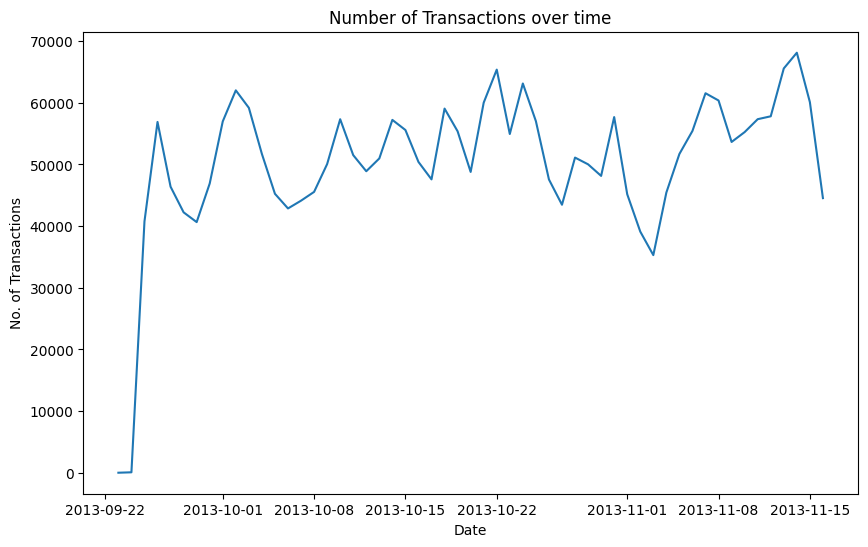

In [ ]:
# Filter out transactions that are in the future (as this cannot be the case)
transactionDF_copy['Time'] = pd.to_datetime(transactionDF_copy['Time'])
cutoff_date = pd.Timestamp(2023, 11, 29)
transactionDF_copy_filtered = transactionDF_copy[transactionDF_copy['Time'] <= cutoff_date]

# Count number of transactions for each date
count_trans = transactionDF_copy_filtered["Date"].value_counts()
count_trans = count_trans.sort_index()

# Create line plot for number of daily transactions over time
plt.figure(figsize = (10, 6))
plt.plot(count_trans)
plt.xlabel("Date")
plt.ylabel("No. of Transactions")
plt.title("Number of Transactions over time")
plt.show()

### Evolution of currency transferred over time

Display a graph that shows the evolution of the amount of currency transferred (in BTC and USD) over time.


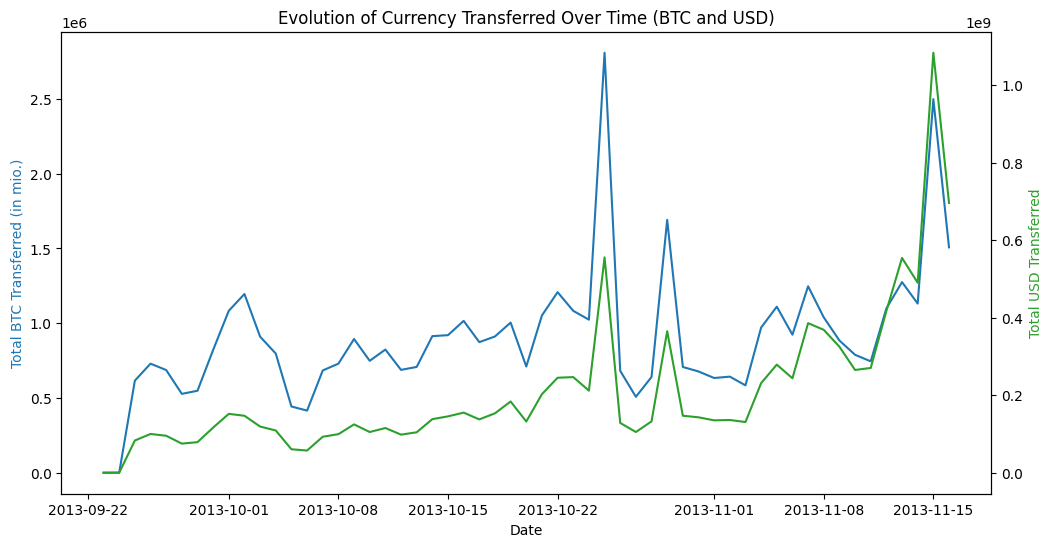

In [ ]:
# Filter out transactions that are in the future (as this cannot be the case)
transactions_df_prices['Time'] = pd.to_datetime(transactions_df_prices['Time'])
cutoff_date = pd.Timestamp(2023, 11, 29)
transactions_df_prices_filtered = transactions_df_prices[transactions_df_prices['Time'] <= cutoff_date]

# Compute daily transaction volume in BTC and USD
daily_total = transactions_df_prices_filtered.groupby("Date").agg({"Sum": "sum", "Sum($)": "sum"})
daily_total.sort_index()

# Plot BTC values on the primary y-axis (left)
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Date')
ax1.set_ylabel('Total BTC Transferred (in mio.)', color='tab:blue')
ax1.plot(daily_total.index, daily_total['Sum'], color='tab:blue')
#ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a secondary y-axis (right) for the USD values
ax2 = ax1.twinx()
ax2.set_ylabel('Total USD Transferred', color='tab:green')
ax2.plot(daily_total.index, daily_total['Sum($)'], color='tab:green')
#ax2.tick_params(axis='y', labelcolor='tab:red')

# Set title and show the plot
plt.title('Evolution of Currency Transferred Over Time (BTC and USD)')
plt.show()

## Exercise 2 [4 points]

Assume you want to create a web site with infomration about bitcoin. In this website, a user could go and get some statistics for any Bitcoin address. You can select the statistics you want to maintain - you should maintain at least three statistics - suggestions: address account balance (mandatory); top-3 commercial partners; average transaction value.

To support this web site, it would be necessary to build one or more indices that would be used to answer the query of the user. In this context a index is a table that maps an address to a value of the statistics being computed.

Write the code to build these indices - for each index, print 5 lines.

**NOTE:** use the data from a single dataset file (even knowing that the value of the account balance would need to include processing all transactions).


Dataset used: "0-68732.csv.gz" (due to limitation of Google Colab to this code on larger datasets)

In [ ]:
# Get unique addresses from the input
unique_addresses = inputDF['Input'].unique()

# Create a dataframe to store the final results
balances_df = pd.DataFrame(columns=['Address', 'Balance'])

# Iterate over unique addresses from the input
for address in unique_addresses:
    # Find the last instance of each address based on time from the input
    last_input_instance = inputDF[inputDF['Input'] == address].sort_values('Time').iloc[-1]

    # Filter output transactions after the time of the last instance
    filtered_output = outputDF[outputDF['Time'] >= last_input_instance['Time']]

    # Aggregate values for that address from the output side
    balance_after_last_input = filtered_output[filtered_output['Output'] == address]['Value'].astype(float).sum()

    # Add the address and balance to the dataframe
    balances_df = balances_df.append({'Address': address, 'Balance': balance_after_last_input}, ignore_index=True)

# Find addresses on the output side which were not present on the input side
output_addresses_not_in_input = set(outputDF['Output'].unique()) - set(unique_addresses)

# Iterate over addresses not in input
for address in output_addresses_not_in_input:
    # Aggregate values for these addresses from the output side
    balance_for_output_address = outputDF[outputDF['Output'] == address]['Value'].astype(float).sum()

    # Add the address and balance to the dataframe
    balances_df = balances_df.append({'Address': address, 'Balance': balance_for_output_address}, ignore_index=True)

# Display the resulting dataframe
print(balances_df.head(5))


# Combine addresses from inputDF and outputDF
combined_addresses = pd.concat([inputDF['Input'], outputDF['Output']])
address_counts = combined_addresses.value_counts().reset_index()
address_counts.columns = ['Address', 'Transaction_Count']

# Get the top 3 addresses by transaction count
top_3_addresses = address_counts.head(3)
print("\nTop-3 Commercial Partners:\n", top_3_addresses)


# Calculate the average transaction value for each output address
avg_tx_value = outputDF.groupby('Output')['Value'].mean().reset_index()
avg_tx_value.columns = ['Address', 'Avg_Transaction_Value']
print("\nAverage Transaction Value:\n", avg_tx_value.head(5))


Streaming output truncated to the last 5000 lines.
<ipython-input-12-3f4112beb283>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balances_df = balances_df.append({'Address': address, 'Balance': balance_for_output_address}, ignore_index=True)
<ipython-input-12-3f4112beb283>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balances_df = balances_df.append({'Address': address, 'Balance': balance_for_output_address}, ignore_index=True)
<ipython-input-12-3f4112beb283>:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balances_df = balances_df.append({'Address': address, 'Balance': balance_for_output_address}, ignore_index=True)
<ipython-input-12-3f4112beb283>:30: FutureWarning: The frame.append method is deprecated and will

                              Address  Balance
0  1DZTzaBHUDM7T3QvUKBz4qXMRpkg8jsfB5     25.0
1  1DCbY2GYVaAMCBpuBNN5GVg3a47pNK1wdi      0.0
2  1KAD5EnzzLtrSo2Da2G4zzD7uZrjk8zRAv     50.0
3  1DNdPgBZRWjDj1JbVZQEYMv7jvqJF7R4Py      0.0
4  1ELmSkQWnqgbBZNzxAZHts3MEYCngqRBeD      0.0

Top-3 Commercial Partners:
                               Address  Transaction_Count
0  18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT               3668
1   1XPTgDRhN8RFnzniWCddobD9iKZatrvH4               3137
2  1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp                600

Average Transaction Value:
                               Address  Avg_Transaction_Value
0  112797aokkr29PDoVE3Gu2VsSHPfa68eM7                  50.00
1  112EPnhrbSKKuc9sMdxxnCL4XAoXcfekzn                  25.39
2  112Kcj4anCh9StuAqaUDyLr7dfgPV3YwS9                   2.26
3  112TB1ebNuyWM4Y1v1CJzuZSmNXjCbVbD3                  26.94
4  112YQngrn5ta9CGbraDnerB7syaXKLJTz7                   5.77


#### Discussion

**Address Account Balance**
Method: This part of the analysis aimed to approximate the change in balance for each address within the dataset. We did so by identifying the last transaction in which each address appeared as an input (sender) and then summing up the values of all output transactions (recipients) that occurred after this last input.

Results: The balances shown represent the total Bitcoin received by these addresses after their last recorded spending within the dataset. For example, 1DZTzaBHUDM7T3QvUKBz4qXMRpkg8jsfB5 received a total of 25.0 BTC after its last outgoing transaction in the dataset used.

Interpretation: These numbers give an idea of recent transaction activities of these addresses but do not represent the current total balance, as they don't include any potential spendings outside the dataset's scope.

**Top-3 Commercial Partners**

Method: This index identified the addresses involved in the highest number of transactions, providing insight into the most active participants.

Results: The addresses 18gBZnsuSrhYLjvPUgwvDUJmksfREUGBTT, 1XPTgDRhN8RFnzniWCddobD9iKZatrvH4, and 1BiRpMGDef8rEDZU6RArzYmBGATQSG1zQp are at the top of the list, with 3668, 3137, and 600 transactions respectively.

Interpretation: These are likely key players within the scope of the dataset, either in terms of trading volume or frequency of transactions.

**Average Transaction Value**
Method: This statistic provides an average of the transaction values for each address based on the output transactions.

Results: Addresses like 112797aokkr29PDoVE3Gu2VsSHPfa68eM7 and 112EPnhrbSKKuc9sMdxxnCL4XAoXcfekzn show average transaction values of 50.00 and 25.39 BTC respectively.

Interpretation: This statistic is useful for understanding the scale of transactions for each address. Higher averages could indicate addresses used for larger transactions, possibly involving significant Bitcoin movements.

**Discussion**
Accuracy: The calculated balances are approximations, representing the net change within the dataset rather than actual current balances. They give insights into recent activities of these addresses in the dataset but may not reflect their complete transaction history.

Data Limitations: The analysis is limited to the data available in the dataset. For more comprehensive insights, a complete transaction history would be needed.

Usefulness: Despite the limitations, these statistics provide valuable insights into the activities of different Bitcoin addresses, particularly for those interested in transaction patterns and behaviors in the Bitcoin network.

## Exercise 3 [4 points]

Explore the creation of classification models for assigning labels to addresses. Use the labels assigned in the provided dataset for training and testing.

**SUGGESTION:** use statistics associated with each address, including number of transactions, avergae amount of transactions, average number of partners per day (or other time unit), etc.

**NOTE:** building the best classification model is a never ending task, and we do not expect you to build a perfect classifier. What we expect you in this task is that you propose a set of variables and explain the relevance of such variable for helping differentiate between different classes, and that do the step to build and evaluate the classifier.


Dataset used: "260001-270000.csv.gz"

### Feature Selection:

**1st Statistic: Number of Total Transactions**

This variable represents the total count of transactions associated with an address. Different types of Bitcoin activities exhibit distinct transaction frequencies. For instance, services transactions might show a regular pattern of transactions, while a gambling site might exhibit a more erratic pattern. Analyzing the number of transactions can provide insights into the nature of the activities an address is involved in.

In [12]:
# 1st Statistic: Number of Total Transactions

# Count number of unique transactions for each address
spark.sql("""
SELECT Input, COUNT(*) as Input_Tx_Count
FROM input
WHERE TxId IN (SELECT TxId FROM transaction)
GROUP BY Input
""").createOrReplaceTempView("inputTxCountView")

spark.sql("""
SELECT Output, COUNT(*) as Output_Tx_Count
FROM output
WHERE TxId IN (SELECT TxId FROM transaction)
GROUP BY Output
""").createOrReplaceTempView("outputTxCountView")

# Combine counts to get total number of transactions for each address
total_tx_count = spark.sql("""
SELECT
    COALESCE(i.Input, o.Output) as Address,
    COALESCE(i.Input_Tx_Count, 0) + COALESCE(o.Output_Tx_Count, 0) as Total_Tx_Count
FROM inputTxCountView i
FULL OUTER JOIN outputTxCountView o ON i.Input = o.Output
""")

**2nd Statistic: Average Amount of Transactions:**

This variable reflects the average value received per address. The average transaction amount could vary significantly across different types of Bitcoin activities. For instance, mining and services transactions might show a relatively consistent and predictable amount, while gambling and exchange transactions might show a wider range of transaction amounts.

In [13]:
# 2nd Statistic: Average Amount of Transactions

# Calculate the sum of output values and the count of transactions per address
spark.sql("""
SELECT output,
       SUM(value) as Total_Output_Value,
       COUNT(*) as Output_Tx_Count
FROM output
GROUP BY Output
""").createOrReplaceTempView("outputAggView")

# Calculate the average output value per transaction for each address
average_output_value = spark.sql("""
SELECT Output,
       Total_Output_Value / Output_Tx_Count as Average_Output_Value
FROM outputAggView
""")
average_output_value.createOrReplaceTempView("average_output_value")

**3rd Statistics: Average number of unique partners per day**

This statistic gives an idea of how many unique addresses an address interacts with on an average day. Addresses involved in public services or commercial activities might interact with a higher number of unique addresses compared to personal wallets. For example, a merchant or a service provider might receive payments from many different addresses.

In [14]:
# 3rd Statistic: Average number of partners per day

# First, we analyze if there are any outliers in the "time" column of the dataset
dataset_sorted_desc = spark.sql("""SELECT DISTINCT Time FROM data ORDER BY Time DESC""")
dataset_sorted_asc = spark.sql("""SELECT DISTINCT Time FROM data ORDER BY Time ASC""")
print("Latest Dates:")
dataset_sorted_desc.show()
print("Earlierst Dates:")
dataset_sorted_asc.show()

Latest Dates:
+-------------------+
|               Time|
+-------------------+
|2070-04-24 08:28:17|
|2070-03-11 13:55:34|
|2035-09-24 02:58:12|
|2013-11-16 23:56:56|
|2013-11-16 23:56:41|
|2013-11-16 23:56:30|
|2013-11-16 23:56:26|
|2013-11-16 23:56:01|
|2013-11-16 23:55:58|
|2013-11-16 23:55:28|
|2013-11-16 23:55:19|
|2013-11-16 23:55:04|
|2013-11-16 23:55:01|
|2013-11-16 23:55:00|
|2013-11-16 23:54:39|
|2013-11-16 23:54:33|
|2013-11-16 23:54:31|
|2013-11-16 23:54:29|
|2013-11-16 23:54:25|
|2013-11-16 23:54:21|
+-------------------+
only showing top 20 rows

Earlierst Dates:
+-------------------+
|               Time|
+-------------------+
|2013-09-23 08:31:57|
|2013-09-23 19:24:06|
|2013-09-23 20:16:39|
|2013-09-23 21:28:05|
|2013-09-23 21:55:44|
|2013-09-23 22:31:52|
|2013-09-23 22:50:17|
|2013-09-23 23:44:32|
|2013-09-24 01:10:35|
|2013-09-24 02:07:11|
|2013-09-24 02:21:02|
|2013-09-24 02:41:03|
|2013-09-24 03:31:02|
|2013-09-24 04:37:47|
|2013-09-24 05:13:01|
|2013-09-24 06:07:4

It seems like there are 3 columns which are dated in the years 2035 or 2070. As this can not be the case, we will drop these columns before we move on.

In [15]:
from pyspark.sql.functions import col, to_date
from datetime import datetime

# Define cutoff date and filter dataset
cutoff_date = datetime(2023, 11, 29)
dataset_filtered = dataset.filter(dataset.Time <= cutoff_date)

# Update views
dataset_filtered.createOrReplaceTempView("data_filtered")
input_filtered = spark.sql("SELECT txid, height, EXPLODE(input) AS input, time FROM data_filtered")
input_filtered.createOrReplaceTempView("input_filtered")
output_filtered = spark.sql("SELECT txid, height, EXPLODE(output) AS output, time FROM data_filtered")
output_filtered = output_filtered.withColumn("output",split(regexp_replace("output","[\[\]]",""),"\,"))
output_filtered = output_filtered.withColumn("value",expr("CAST(output[1] AS FLOAT)"))
output_filtered = output_filtered.withColumn("output",expr("output[0]"))
output_filtered.createOrReplaceTempView("output_filtered")

Now, we can compute the average number of unique partners per day:

In [16]:
from pyspark.sql.functions import to_date, countDistinct, col

# First, we merge the input and output DataFrame to be able to calculate the number of unique partners per day:
mergedSDF = spark.sql("""
    SELECT
        i.txid,
        i.input,
        o.output,
        to_date(i.time) AS date
    FROM input_filtered i
    JOIN output_filtered o ON i.txid = o.txid
""")
mergedSDF.createOrReplaceTempView("mergedSDF")

In [17]:
# Check whether there are any empty cells in the mergedSDF

from pyspark.sql.functions import col, count, when, isnan

null_count = mergedSDF.where(col("output").isNull()).count()
nan_count = mergedSDF.where(isnan("output")).count()

print("Number of NULL values in column 'output':", null_count)
print("Number of nan values in column 'output':", nan_count)


Number of NULL values in column 'output': 0
Number of nan values in column 'output': 0


In [18]:
# Calculate average number of unique partners per day

from pyspark.sql.functions import sum as sum_

# Compute total number of days in dataset
date_range = mergedSDF.select(min("date"), max("date")).first()
total_days = (date_range["max(date)"] - date_range["min(date)"]).days + 1

# Compute total number of unique partners for input and output addresses and union the result
total_partners_input = mergedSDF.groupBy("input").agg(countDistinct("output").alias("totalUniquePartners"))
total_partners_input = total_partners_input.withColumnRenamed("input", "address")
total_partners_output = mergedSDF.groupBy("output").agg(countDistinct("input").alias("totalUniquePartners"))
total_partners_output = total_partners_output.withColumnRenamed("output", "address")
combined_total_partners = total_partners_input.union(total_partners_output)

# Divide total number of partners by total number of days to get total number of unique partners per day for each address
average_partners_per_day = combined_total_partners.groupBy("address")\
                                             .agg((sum_("totalUniquePartners") / total_days)\
                                             .alias("avgUniquePartnersPerDay"))

**4th Statistic: Transaction Variability**

This feature reflects the standard deviation in transaction amounts received. Addresses involved in specific activities might show more variability in transaction amounts than others.

In [ ]:
# 4th Statistic: Transaction Variability

from pyspark.sql.functions import stddev

output_stddev = output_filtered.groupBy("output").agg(stddev("value").alias("std_dev_amount"))
output_stddev = output_stddev.withColumnRenamed("output", "address")
output_stddev_filled = output_stddev.fillna({"std_dev_amount": 0})


In [ ]:
# Printing all DataFrames which contain features for the classification model

total_tx_count.show()
average_output_value.show()
average_partners_per_day.show()
output_stddev_filled.show()

+--------------------+--------------+
|             Address|Total_Tx_Count|
+--------------------+--------------+
|'1111111111111116...|             1|
|'11111111111197nB...|             1|
|'11111111111iiRF4...|             1|
|'11111111111iiRUD...|             1|
|'11111111111jReUw...|             1|
|'1111111118AQGAvS...|             1|
|'11111111wkCcmEDq...|             1|
|'111111133PTRrQoa...|             1|
|'111133WxWTrHrru3...|             2|
|'11123W1RoxwJwRDs...|             1|
|'111261jkkpLpyEWg...|             2|
|'111272UBF73erWgo...|             1|
|'11127gWen42YgRzS...|             4|
|'11129zjSZRjtRMub...|             2|
|'1112BsBd62NhVrwT...|             1|
|'1113hFG857ykQSEW...|             3|
|'111DxJtEbwsHKRRT...|             7|
|'111J2A44Q7KjMT6m...|             1|
|'111LVq6mwrW3kQJq...|             1|
|'111YR9ZACSXPUikG...|             4|
+--------------------+--------------+
only showing top 20 rows

+--------------------+--------------------+
|              Out

In [ ]:
# Now, we join all DataFrames that contain features for the classification models into one DataFrame

# First, we rename the address column to "address" for all DataFrames so they can all be joined

from pyspark.sql.functions import coalesce

total_tx_count_renamed = total_tx_count.withColumnRenamed("Address", "address")
average_output_value_renamed = average_output_value.withColumnRenamed("Output", "address")

# Combine all DataFrames and fill the NULL/NAN values with 0

featuresSDF = total_tx_count_renamed.join(average_output_value_renamed, "address", "full_outer")\
                                    .join(average_partners_per_day, "address", "full_outer")\
                                    .join(output_stddev_filled, "address", "full_outer")
featuresSDF = featuresSDF.fillna({"Total_Tx_Count": 0,
                                  "Average_Output_Value": 0,
                                  "AvgUniquePartnersPerDay": 0,
                                  "Std_Dev_Amount": 0})

# Next, we join the resulting DataFrame with the labels dataset
features_df_joined = featuresSDF.join(labelsSDF.select("address", "type"), on="address", how="left")
features_df_joined_filtered = features_df_joined.filter(features_df_joined.type.isNotNull())

In [ ]:
# Now that we have the DataFrame with the calculated features for all addresses, we will create a subset of this DataFrame
# and store it locally for the purpose of reusability and manageability

features_df_joined_filtered_subset = features_df_joined_filtered.sample(fraction=0.1) # 10% of all entries
features_df_joined_filtered_subset_pd = features_df_joined_filtered_subset.toPandas()

output_path = '/content/drive/My Drive/features_subset.csv'

features_df_joined_filtered_subset_pd.to_csv(output_path, index=False)

In [ ]:
# Read the subset of the Features DataFrame into Colab

path_subset = '/content/drive/My Drive/features_subset.csv'

features_df = pd.read_csv(path_subset)

features_df.head(20)

,address,Total_Tx_Count,Average_Output_Value,avgUniquePartnersPerDay,std_dev_amount,type
0,'112EXhpBUYZgG8kcMQGZGxsjLhY53XABgN',2,1.502600,0.109091,0.000000e+00,service
1,'112RVVZCLB2znd9kkaZbkhRG8mk5QmKHJA',2,28.036312,0.036364,0.000000e+00,service
2,'112d62ytcf7vC8j3DffixpdURwcJhSxyN7',2,0.200000,0.072727,0.000000e+00,historic
3,'112f5xRwMo26Rx2t3wi1zybBAvHa8EHaVD',1,0.000000,0.036364,0.000000e+00,historic
4,'112syq5gt5dUi4WHkTtFHU3eCuLGki3RSy',1,0.000000,0.036364,0.000000e+00,historic
5,'113GnTxKDe6xPqmFCVhvpMW8wsWcaejzPm',1,0.010031,0.018182,0.000000e+00,historic
6,'114Cf8ww5L1eu5kHwHUN4at5MgbiJupi58',2,1.410000,0.054545,0.000000e+00,historic
7,'114DJtZvFDebgQyeG4uwecqenLJkMvy8vZ',5,0.000210,0.090909,1.065639e-04,service
8,'114SQm4aAwiqB35vTiXyHTQZivttyYKJx6',2,0.016900,0.054545,0.000000e+00,historic
9,'114YHBfPMXbJjwhw8JVMinTVDEcRavtYux',2,0.023474,0.109091,0.000000e+00,historic


In [ ]:
features_df.shape

(25876, 6)

### Model Building:

After preparing our features, we'll now apply two classification models: **Support Vector Machines (SVM)** and **Random Forest**.

These models are chosen for their distinct strengths in handling complex datasets.

**Support Vector Machines:**

In [ ]:
# Here, the 'RandomizedSearchCV' approach is chosen over the GridSearchCV as it is less time-consuming and takes up less resources.

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

# Separate features and target variable
X = features_df[["Total_Tx_Count", "Average_Output_Value", "avgUniquePartnersPerDay", "std_dev_amount"]]
y = features_df["type"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Instantiate classifier with default hyperparameters
svc = svm.SVC()

# Declare parameters for hyperparameter tuning
parameters = {
    "C": [1, 10, 100],
    "kernel": ["rbf", "linear"],
    "gamma": [0.1, 0.5, 1]
}

# Perform Randomized Search with fewer iterations and CV folds
random_search = RandomizedSearchCV(estimator=svc, param_distributions=parameters, n_iter=10, scoring="accuracy", cv=2, random_state=0)
random_search.fit(X_train_scaled, y_train)

# Best estimator and its score
best_estimator = random_search.best_estimator_
best_score = random_search.best_score_

# Evaluate on the test set
y_pred = best_estimator.predict(X_test_scaled)
class_report = classification_report(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Display outputs
print("Best Estimator:", best_estimator)
print("Best Score:", best_score)

class_report = classification_report(y_test, y_pred)
print("\nClassification Report (SVM):\n")
print(class_report)

Best Estimator: SVC(C=100, gamma=1)
Best Score: 0.56

Classification Report:

              precision    recall  f1-score   support

   exchanges       0.49      0.16      0.24       886
    gambling       0.00      0.00      0.00       215
    historic       0.53      0.93      0.68      2335
      mining       0.00      0.00      0.00        12
     service       0.73      0.34      0.46      1728

    accuracy                           0.56      5176
   macro avg       0.35      0.29      0.28      5176
weighted avg       0.57      0.56      0.50      5176



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Random Forest:**

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Define Random Forest classifier
rf = RandomForestClassifier()

# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Perform Randomized Search
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=2, random_state=0)
rf_random_search.fit(X_train_scaled, y_train)

# Evaluate the best model
best_rf = rf_random_search.best_estimator_
y_pred_rf = best_rf.predict(X_test_scaled)
class_report_rf = classification_report(y_test, y_pred_rf)

# Display outputs
print("Best Random Forest Estimator:", rf_random_search.best_estimator_)
print("Best Score:", rf_random_search.best_score_)
print("\nClassification Report (Random Forest):\n")
print(class_report_rf)

Best Random Forest Estimator: RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=200)
Best Score: 0.6242995169082126

Classification Report (Random Forest):

              precision    recall  f1-score   support

   exchanges       0.52      0.37      0.43       886
    gambling       0.00      0.00      0.00       215
    historic       0.61      0.84      0.71      2335
      mining       0.00      0.00      0.00        12
     service       0.70      0.54      0.61      1728

    accuracy                           0.62      5176
   macro avg       0.37      0.35      0.35      5176
weighted avg       0.60      0.62      0.60      5176



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Discussion

The results from the Support Vector Machine (SVM) and Random Forest (RF) models offer insightful comparisons in terms of their performance and suitability for the classification task at hand.

**SVM:**

Starting with the SVM, the best estimator is 'SVC(C=100, gamma=1)', which indicates a relatively high value of C (regularization parameter), suggesting that the model is giving more weight to correctly classifying each training example.This estimator achieved a cross-validated accuracy score of 0.56, indicating a moderate level of predictive ability.

The classification report reveals certain disparities in class-wise performance. For instance, the model shows reasonable precision in classifying the 'service' class but struggles significantly with classes like 'gambling' and 'mining', where both precision and recall are zero. The high recall yet lower precision for 'historic' suggests a tendency of the model to over-predict this class, possibly at the expense of others. Overall, the SVM model demonstrates an uneven performance across different classes, suggesting it might be overfitting certain classes while failing to adequately capture the characteristics of others.

It is worth mentioning that, for the SVM technique, the Randomized Search was chosen over the GridSearch due to the intensive time and resource requirements by the GridSearch approach. In order to achieve a higher accuracy, the GridSearch should be executed as the RandomizedSearch might have missed the absolute best combination of parameters that could be found by the exhaustive search of GridSearch. This is because the RandomizedSearch samples a fixed number of parameter combinations from the specified parameter space, rather than exhaustively trying every combination.

**Random Forest:**

On the other hand, the Random Forest model exhibits a better overall performance with a higher cross-validated accuracy of about 0.62. The best estimator is 'RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=200)'. This configuration suggests a controlled depth of trees and a moderate number of trees in the forest, indicating a balance between model complexity and overfitting

 It shows improvements in the precision and recall values for most classes compared to the SVM model. Notably, there's a marked increase in the performance metrics for the 'exchanges' and 'service' classes. However, like the SVM, the Random Forest model also struggles with the 'gambling' and 'mining' classes, indicating that these classes are challenging to predict, possibly due to fewer training examples or less distinctive features. The improvement in the recall for 'historic' and better-balanced precision across classes suggests a more robust generalization capability in the Random Forest model.

 **Comparison:**

 The differences in performance between the two models can be attributed to their inherent characteristics. SVM's lower performance might be due to its sensitivity to the choice of kernel and hyperparameters, especially in a high-dimensional space. In contrast, Random Forest's ensemble approach, which aggregates decisions from multiple decision trees, seems to offer a more balanced and robust prediction across various classes, even though it still struggles with certain classes.

 **Conclusion:**

 In summary, while both models show potential in classifying the dataset, the Random Forest model appears to be more effective overall, offering a better balance across different classes. However, the consistent underperformance on certain classes by both models suggests the need for further investigation, feature engineering, or alternative modeling approaches to improve predictions for these specific categories.

## Exercise 4 [4 points]

Consider we didn't have the labels for the address, but that you would want to create groups of addresses. Propose a solution.


Dataset used: "260001-270000.csv.gz"

The primary goal for grouping Bitcoin addresses without having labels is to discover inherent structures or patterns in the data. For this, Clustering algorithms are the most suitable approach.

In this exercise, we will use 2 common Clustering algorithms:

**K-Means:** This is a popular method for partitioning the data into K distinct, non-overlapping subgroups (or clusters) where each data point belongs to only one group.

**Density-Based Spatial Clustering of Applications with Noise (DBSCAN):** This algorithm groups together points that are closely packed together and marks as outliers the points that lie alone in low-density regions. This method is good for data which contains clusters of similar density.

In [56]:
# Read the Features Dataset and drop the labels

path_subset = '/content/drive/My Drive/features_subset.csv'

features_df = pd.read_csv(path_subset)
features_df.drop(columns = 'type',axis = 1, inplace = True)

features_df.head()

,address,Total_Tx_Count,Average_Output_Value,avgUniquePartnersPerDay,std_dev_amount
0,'112EXhpBUYZgG8kcMQGZGxsjLhY53XABgN',2,1.502600,0.109091,0.0
1,'112RVVZCLB2znd9kkaZbkhRG8mk5QmKHJA',2,28.036312,0.036364,0.0
2,'112d62ytcf7vC8j3DffixpdURwcJhSxyN7',2,0.200000,0.072727,0.0
3,'112f5xRwMo26Rx2t3wi1zybBAvHa8EHaVD',1,0.000000,0.036364,0.0
4,'112syq5gt5dUi4WHkTtFHU3eCuLGki3RSy',1,0.000000,0.036364,0.0


### K-Means:

In [112]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

clustering_features = features_df[["Total_Tx_Count", "Average_Output_Value", "avgUniquePartnersPerDay", "std_dev_amount"]]

# Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_features)

# Define function to perform clustering of data with K clusters and returning the respective Silhouette score
def evaluate(dataset, k):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=1)
    labels = kmeans.fit_predict(dataset)
    score = silhouette_score(dataset, labels)
    return score

# For each value from 2 to 20, compute the clusters and the score
cluster_scores = pd.DataFrame(columns=["num", "score"])
for i in range(2, 20):
    score = evaluate(features_scaled, i)
    cluster_scores = cluster_scores.append({"num": i, "score": score}, ignore_index=True)

<ipython-input-112-b30b9ecbf36a>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_scores = cluster_scores.append({'num': i, 'score': score}, ignore_index=True)
<ipython-input-112-b30b9ecbf36a>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_scores = cluster_scores.append({'num': i, 'score': score}, ignore_index=True)
<ipython-input-112-b30b9ecbf36a>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_scores = cluster_scores.append({'num': i, 'score': score}, ignore_index=True)
<ipython-input-112-b30b9ecbf36a>:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cluster_scores = cluster_scores.append({'num': i, 'sco

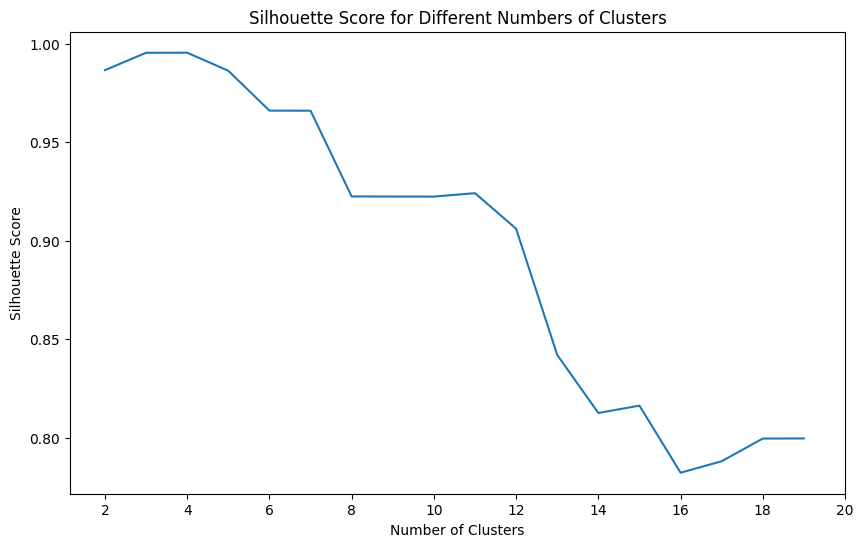

     num     score
0    2.0  0.986718
1    3.0  0.995531
2    4.0  0.995559
3    5.0  0.986395
4    6.0  0.966133
5    7.0  0.966096
6    8.0  0.922522
7    9.0  0.922481
8   10.0  0.922453
9   11.0  0.924182
10  12.0  0.906105
11  13.0  0.841959
12  14.0  0.812477
13  15.0  0.816203
14  16.0  0.782118
15  17.0  0.787959
16  18.0  0.799478
17  19.0  0.799541


In [113]:
# Plot the Silhouette scores
# x-axis and y-axis values for plotting
x = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
y = [3, 1, 4, 5, 3, 6]

plt.figure(figsize = (10, 6))
plt.plot(cluster_scores["num"], cluster_scores["score"])
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.xticks(x)
plt.show()

# Also print the values
print(cluster_scores)

In [114]:
# Determine the optimal number of clusters
optimal_clusters = int(cluster_scores.nlargest(1, "score")["num"].values[0])
print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 4


The Silhouette scores are exceptionally high for almost all the number of clusters, having values above 90% for almost all number of clusters and even reaching 99% for 3 and 4 clusters. This indicates that the objects are well matched to their own clusters and poorly matched to neighboring clusters.

All in all, the scores remain consistently high for a wide range of cluster numbers, only starting to decrease slightly as the number of clusters increases beyond 10.

As 4 clusters achieve the highest score, we will choose this number for the k-means algorithm.

In [115]:
# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, n_init="auto", random_state=1)
labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the DataFrame
features_df["Cluster"] = labels


cluster_counts = features_df["Cluster"].value_counts()
cluster_share = (cluster_counts / features_df["Cluster"].count()) * 100
print(f"Output for {optimal_clusters} clusters:\n")
print("Number of Transactions for each cluster:\n", cluster_counts)
print("Share of Transactions for each cluster: (in %):\n", cluster_share)

Output for 4 clusters:

Number of Transactions for each cluster:
 0    25869
3        3
2        2
1        2
Name: Cluster, dtype: int64
Share of Transactions for each cluster: (in %):
 0    99.972948
3     0.011594
2     0.007729
1     0.007729
Name: Cluster, dtype: float64


The clustering results with K-Means for 4 clusters show a highly imbalanced distribution of data points across the clusters where cluster 0 includes the overwhelming majority of the data points (99.97%). The other 3 clusters only contain 2 or 3 data points each which is why they could represent unique or outlier data points that are significantly different from the majority of the data.

The highly imbalance distribution could be due to several reasons, one of which is that the chosen number of clusters (in this case, 4) might not align with the natural grouping in the data.

Therefore, we are executing the same algorithm again, but with more clusters (8, 12 and 15):

In [116]:
# 8 clusters:

# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=8, n_init="auto", random_state=1)
labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the DataFrame
features_df["Cluster"] = labels


cluster_counts = features_df["Cluster"].value_counts()
cluster_share = (cluster_counts / features_df["Cluster"].count()) * 100
print("Output for 8 clusters:\n")
print("Number of Transactions for each cluster:\n", cluster_counts)
print("Share of Transactions for each cluster: (in %):\n", cluster_share)

Output for 8 clusters:

Number of Transactions for each cluster:
 0    25495
6      318
5       35
3       11
7       10
4        3
2        2
1        2
Name: Cluster, dtype: int64
Share of Transactions for each cluster: (in %):
 0    98.527593
6     1.228938
5     0.135260
3     0.042510
7     0.038646
4     0.011594
2     0.007729
1     0.007729
Name: Cluster, dtype: float64


In [117]:
# 15 clusters:

# Perform K-Means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=15, n_init="auto", random_state=1)
labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the DataFrame
features_df["Cluster"] = labels


cluster_counts = features_df["Cluster"].value_counts()
cluster_share = (cluster_counts / features_df["Cluster"].count()) * 100
print("Output for 15 clusters:\n")
print("Number of Transactions for each cluster:\n", cluster_counts)
print("Share of Transactions for each cluster: (in %):\n", cluster_share)

Output for 15 clusters:

Number of Transactions for each cluster:
 13    23961
0      1415
11      272
14      134
5        26
6        25
10       13
3        11
7        10
2         2
8         2
12        2
1         1
4         1
9         1
Name: Cluster, dtype: int64
Share of Transactions for each cluster: (in %):
 13    92.599320
0      5.468388
11     1.051167
14     0.517854
5      0.100479
6      0.096615
10     0.050240
3      0.042510
7      0.038646
2      0.007729
8      0.007729
12     0.007729
1      0.003865
4      0.003865
9      0.003865
Name: Cluster, dtype: float64


The clustering results using 8 and 15 clusters with K-Means still reveal a highly imbalanced distribution, consistently dominated by one major cluster. In the 8-cluster scenario, around 98.53% of the data is grouped into a single cluster, with the remainder scattered across smaller clusters. Increasing the number of clusters to 15 still results in one dominant cluster holding 92.60% of the data, while the other clusters remain significantly smaller, many containing only a handful of data points.

The persistence of this imbalance, despite varying the number of clusters, points to potential limitations in either the feature selection or the clustering algorithm itself.

Therefore, we will apply another Clustering algorithm to see if this could yield different insights. Here, we are using the DBSCAN algorithm.

### DBSCAN:

In [118]:
from sklearn.cluster import DBSCAN

# Extracting features for clustering
clustering_features = features_df[["Total_Tx_Count", "Average_Output_Value", "avgUniquePartnersPerDay", "std_dev_amount"]]

# Standardize  features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(clustering_features)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(features_scaled)

# Add the DBSCAN cluster labels to DataFrame
features_df["DBSCAN_Cluster"] = clusters

# Print results
cluster_counts_DBSCAN = features_df["DBSCAN_Cluster"].value_counts()
cluster_share_DBSCAN = (cluster_counts_DBSCAN / features_df["DBSCAN_Cluster"].count()) * 100
print("Number of Transactions for each cluster:\n", cluster_counts_DBSCAN)
print("Share of Transactions for each cluster: (in %):\n", cluster_share_DBSCAN)

Number of Transactions for each cluster:
  0     25724
-1        95
 3         9
 5         7
 2         6
 7         6
 1         5
 4         5
 8         5
 6         5
 9         5
 10        4
Name: DBSCAN_Cluster, dtype: int64
Share of Transactions for each cluster: (in %):
  0     99.412583
-1      0.367136
 3      0.034781
 5      0.027052
 2      0.023188
 7      0.023188
 1      0.019323
 4      0.019323
 8      0.019323
 6      0.019323
 9      0.019323
 10     0.015458
Name: DBSCAN_Cluster, dtype: float64


In the DBSCAN algorithm, the largest cluster contains 25,724 points (99.4% of all points), which is similar to the dominant cluster observed in the K-Means results. This suggests that a large portion of the data points are very similar to each other, at least in terms of the features selected for clustering.

DBSCAN identified 95 points as noise (cluster -1). These are data points that do not fit well into any cluster based on the *eps* (the maximum distance between two samples for one to be considered as in the neighborhood of the other) and *min_samples* (the number of samples in a neighborhood for a point to be considered as a core point) parameters set for DBSCAN.

#### Conclusion

In the **K-Means** clustering approach, where various numbers of clusters were tested (4, 8 & 15), a consistent pattern emerged: a single dominant cluster comprising the vast majority of the data points, with remaining clusters significantly smaller in size. This indicates a high degree of homogeneity among the Bitcoin addresses based on the selected features. The smaller clusters, although minimal in size, suggested the presence of niche or unique transaction behaviors within the dataset. However, the overwhelming dominance of a single cluster in all scenarios hinted at either a limitation in the feature set's ability to capture diverse patterns or an inherent similarity in the majority of the data.

The **DBSCAN** algorithm also dentified a primary cluster containing a large majority of data points. Nevertheless, it also revealed a small number of data points as outliers, suggesting these points do not fit well into the general structure captured by other clusters. Additionally, DBSCAN identified several smaller clusters, each distinct from the main cluster, which could represent specific, less common types of Bitcoin transactions (such as *Mining* transactions which occurr very rarely in the dataset).

In the end, in order to group the Bitcoin addresses more successfully, additional features have to be explored and included in the clustering algorithms. he current feature set, while providing some initial insights, seems to have limitations in capturing the full spectrum of behaviors and characteristics inherent in the dataset. Diversifying and enriching the feature set could potentially reveal more distinct and meaningful clusters, thereby offering a more nuanced understanding of the Bitcoin addresses.

## Exercise 5 [3+1 points]

Propose a problem to solve and implement it (for 3 points).

Use cuDF/cuML/cuGrpahs for 1 extra point.

In [ ]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12 cuml-cu12 cugraph-cu12

In [ ]:
import cudf

In [ ]:
# All data in 'Input' and 'Output' are strings
df['Input'] = df['Input'].astype(str)
df['Output'] = df['Output'].astype(str)

# Now convert the DataFrame to cuDF
gdf = cudf.from_pandas(df)

# Calculate total transaction volume for each address
total_volume = gdf.groupby('Output_Address')['Transaction_Amount'].sum().reset_index()
total_volume.columns = ['Address', 'Total_Volume']

# Calculate transaction frequency for each address
freq = gdf['Output_Address'].value_counts().reset_index()
freq.columns = ['Address', 'Frequency']

# Merge total volume and frequency data
merged_data = total_volume.merge(freq, on='Address')

# Rank addresses based on total volume and frequency
merged_data['Rank'] = merged_data['Total_Volume'] + merged_data['Frequency']  # Modify ranking criteria as needed
top_addresses = merged_data.nlargest(5, 'Rank')

# Display top 5 influential addresses
print(top_addresses)

                                  Address  Total_Volume  Frequency     Rank
10905  1EMPhwUXHGURtSdt5zidbV3zPKruDTKYX9       72000.0          6  72006.0
5108   138eoqfNcEdeU9EG9CKfAxnYYz62uHRNrA       49384.0         10  49394.0
2849   1PREkEVoQcNa6rrB8W22PWPYzjFxiq42RH       48000.0          3  48003.0
13047  1GEECfBjkeUMCf3TNWCHvXZKKjnjjra7tC       44600.0          9  44609.0
10361  16WvoYoAdPRja4g5SnKxiXmGxXKTj41toS       37854.0         46  37900.0


#### Discussion

The goal of this task is to analyze Bitcoin transaction data to identify the most influential Bitcoin addresses based on transaction volume and frequency. Here's a breakdown and discussion of our code and its results:
* 		Data Type Conversion:
    * The initial step ensures that the data in the 'Input' and 'Output' columns are strings. This is crucial for subsequent operations, as the data must be in a consistent and processable format.
* 		Conversion to cuDF DataFrame:
    * The Pandas DataFrame is converted to a cuDF DataFrame. cuDF, part of the RAPIDS suite, is designed to enable fast data manipulation and analysis on GPUs. This step optimizes performance, especially beneficial for large datasets.
* 		Transaction Volume Calculation:
    * The code computes the total transaction volume for each Bitcoin address. This is done by grouping the data by 'Output_Address' and summing up the 'Transaction_Amount' for each group. This calculation gives insight into the total amount of Bitcoin handled by each address.
* 		Transaction Frequency Calculation:
    * Frequency is calculated by counting the occurrences of each 'Output_Address'. This reflects how often each address appears in transactions, indicating its activity level in the network.
* 		Merging Volume and Frequency Data:
    * The total volume and frequency data are merged into a single DataFrame. This step combines the two key metrics (volume and frequency) for each address.
* 		Ranking Addresses:
    * Addresses are ranked based on a combined score of total volume and frequency. The rank is calculated by simply adding these two metrics. This ranking method assumes that both volume and frequency are equally important in determining an address's influence.
* 		Displaying Top Addresses:
    * The top 5 addresses, based on the calculated rank, are displayed. This list represents the most influential addresses in your dataset according to the defined criteria.

**Discussion of Results:**
* The output shows the top 5 addresses with their corresponding total transaction volumes, frequencies, and calculated ranks. For instance, the address '1EMPhwUXHGURtSdt5zidbV3zPKruDTKYX9' ranks highest with a total volume of 72,000 and a frequency of 6, leading to a rank score of 72,006.
* These results provide valuable insights into the behavior and influence of participants in the Bitcoin network. High-ranking addresses could be major traders, exchanges, or other significant players.
* It's important to note that this analysis is limited by the criteria used for ranking (volume and frequency). Different results might be obtained if other factors, such as transaction time or network centrality, were considered.
* The usage of cuDF significantly improves the performance of data processing, especially beneficial when dealing with large-scale datasets like those typical in blockchain analysis.
In conclusion, our code effectively identifies and ranks influential Bitcoin addresses based on transaction volume and frequency, providing a snapshot of key players in the Bitcoin network. However, the interpretation of these results should consider the scope and limitations of the analysis criteria.